### Eulerian autocovariance  filtered and demodulated signal
cf github/zcasparco/equinox_phd/llc4320/signal_filtering_store.ipynb for filtering and demodulation method

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp


from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=5)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
#Load demodulated field
ds = xr.open_zarr(ut.work_data_dir+'diags/Eta_autocov.zarr')
grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]
#grd = grd.chunk({'i':100,'j':100})
#ds = xr.merge([ds,grd])
ds

/dev/shm/pbs.45480.datarmor0/ipykernel_37014/959857430.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]


,Array,Chunk
Bytes,36.26 GiB,93.10 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 792, 321)"
Count,599 Tasks,598 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.26 GiB,93.10 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 792, 321)"
Count,599 Tasks,598 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [4]:
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
#ds = ds.persist()
#N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
#              bins=[lon_bins, lat_bins], 
#              dim=['i', 'j', 'face']
#             ).persist()


In [11]:
ds = ds.unify_chunks().persist()
#ds = ds.chunks({'i':-1,'j':-1})

In [12]:
ds

,Array,Chunk
Bytes,36.26 GiB,31.74 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 270, 321)"
Count,1690 Tasks,1690 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.26 GiB,31.74 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 270, 321)"
Count,1690 Tasks,1690 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [7]:
#grd = grd.chunks({'i':400,'j':100})


ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
#ds['Depth'] = grd.Depth.isel(i=slice(0,None,4),j=slice(0,None,4))
#ds = ds.persist()

In [8]:
print(ds.lat.rename('lat'),ds.lon.rename('lon'))

<xarray.DataArray 'lat' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 <xarray.DataArray 'lon' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12


In [13]:
N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

In [14]:
N.plot()

KeyError: "('rechunk-merge-e1c445c8da386c25917fd7b115dcf568', 12, 0, 0)"

In [8]:
ds_binned = xr.concat([(histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),bins=[lon_bins, lat_bins], weights=ds.correlation.isel(lags=i).fillna(0.),
                  dim=['i', 'j', 'face']
                 )/(N/2)).rename('rr') for i in range(ds.lags.size)], dim='lags')

AttributeError: 'Dataset' object has no attribute 'correlation'

In [39]:
test = (histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),bins=[lon_bins, lat_bins], weights=ds.Crr.isel(lags=0).fillna(0.),dim=['i', 'j', 'face'])/N).persist()

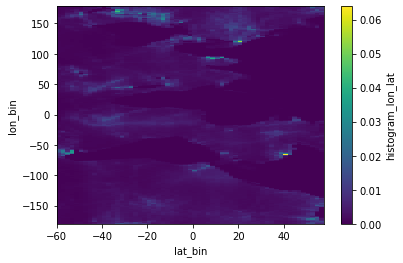

In [11]:
test.plot()

In [29]:
ds.unify_chunks()

,Array,Chunk
Bytes,36.26 GiB,66.12 MiB
Shape,"(13, 1080, 1080, 321)","(1, 100, 270, 321)"
Count,2613 Tasks,1092 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.26 GiB,66.12 MiB
Shape,"(13, 1080, 1080, 321)","(1, 100, 270, 321)"
Count,2613 Tasks,1092 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [31]:
ds = ds.unify_chunks()
#chunks({'i':1,'j':1})
ds

,Array,Chunk
Bytes,36.26 GiB,66.12 MiB
Shape,"(13, 1080, 1080, 321)","(1, 100, 270, 321)"
Count,2613 Tasks,1092 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.26 GiB,66.12 MiB
Shape,"(13, 1080, 1080, 321)","(1, 100, 270, 321)"
Count,2613 Tasks,1092 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [10]:
ds_binned = xr.concat([histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),bins=[lon_bins, lat_bins], 
                                 weights=ds.Crr.isel(lags=i).fillna(0.),dim=['i', 'j', 'face']
                                ).persist() for i in range(ds.lags.size)],dim='lags')

In [11]:
ds_binned = (ds_binned/N).rename('rr').persist()

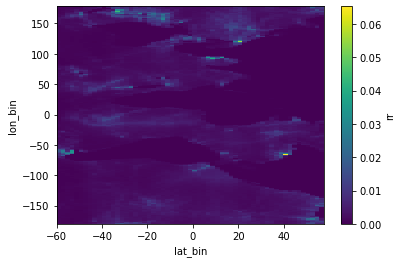

In [12]:
ds_binned.isel(lags=0).plot()

In [25]:
_ds_binned = xr.concat([histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),bins=[lon_bins, lat_bins],
                                  weights=ds.Cri.isel(lags=i).fillna(0.),
                  dim=['i', 'j', 'face']).persist() for i in range(ds.lags.size)], dim='lags')

AttributeError: 'Dataset' object has no attribute 'Cri'

In [14]:
_ds_binned = (_ds_binned/N).rename('ri').persist()

In [26]:
#ds_out = xr.merge([ds_binned,_ds_binned,N.rename('count')])
ds_out = ds_binned
ds_out = ds_out.assign_coords({'lags':ds.lags})

In [27]:
ds_out

<xarray.DataArray 'rr' (lags: 321, lon_bin: 179, lat_bin: 59)>
dask.array<truediv, shape=(321, 179, 59), dtype=float64, chunksize=(1, 179, 59), chunktype=numpy.ndarray>
Coordinates:
  * lon_bin  (lon_bin) float64 -179.0 -177.0 -175.0 -173.0 ... 173.0 175.0 177.0
  * lat_bin  (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0

In [28]:
ds_out = ds_out.rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})

In [29]:
ds_out = ds_out.persist()

In [30]:
ds_out.attrs.update({'binsize':dl})

In [31]:
ds_out = ds_out.compute()

ds_out

<xarray.DataArray 'rr' (lags: 321, lon_bins: 179, lat_bins: 59)>
array([[[ 2.08006110e-02,  2.91229481e-02,  8.42650960e-02, ...,
          9.39282713e-03,  1.03532933e-02,  8.39935087e-03],
        [ 1.69048202e-02,  3.30466402e-02,  8.42345373e-02, ...,
          1.16630884e-02,  8.09918385e-03,  9.52308586e-03],
        [ 1.55225678e-02,  3.44698599e-02,  7.32129301e-02, ...,
          1.13964114e-02,  7.91730564e-03,  1.31561893e-02],
        ...,
        [ 2.91375080e-02,  5.46084147e-02,  8.72106311e-02, ...,
          1.01761869e-02,  8.54692908e-03,  1.27329751e-02],
        [ 2.36408934e-02,  5.89811319e-02,  6.03312546e-02, ...,
          1.12609105e-02,  9.73748144e-03,  9.91981557e-03],
        [ 2.13187185e-02,  4.69414254e-02,  5.69691917e-02, ...,
          1.30438694e-02,  1.49704315e-02,  1.01006840e-02]],

       [[ 2.07044703e-02,  2.89841912e-02,  8.40467399e-02, ...,
          9.31300510e-03,  1.02867509e-02,  8.33366682e-03],
        [ 1.68180129e-02,  3.29186997e-02,  8.40712129e-02, ...,
          1.15752272e-02,  8.03810519e-03,  9.46079629e-03],
        [ 1.54416152e-02,  3.43315776e-02,  7.30530444e-02, ...,
          1.13102268e-02,  7.85776129e-03,  1.30622301e-02],
...
        [ 3.01350827e-04, -4.04774700e-05, -4.79537205e-03, ...,
         -6.11785623e-04, -4.71009741e-04,  1.56241447e-03],
        [ 8.93303035e-05,  1.35435851e-03,  1.22166668e-03, ...,
         -9.07730610e-04, -5.67015344e-04,  6.85374798e-04],
        [-2.83907046e-04, -2.85402341e-03,  4.18923556e-03, ...,
          1.19351393e-03, -4.72417768e-04, -4.12804342e-04]],

       [[-1.69298909e-03, -8.72330823e-04, -4.69548219e-03, ...,
         -4.45936562e-04,  1.05980758e-04, -2.92681998e-04],
        [ 5.03465672e-04, -1.78295063e-03, -4.79180410e-03, ...,
          1.41134666e-04, -7.95513921e-04, -2.40572238e-04],
        [-2.76152995e-04, -1.69519890e-04, -4.58518574e-03, ...,
          6.03717294e-05, -5.65041131e-04, -9.19578088e-04],
        ...,
        [ 2.98457438e-04,  1.51452479e-05, -4.61511607e-03, ...,
         -5.93891826e-04, -4.46317890e-04,  1.59656228e-03],
        [ 5.00610593e-05,  1.36847445e-03,  1.21726306e-03, ...,
         -8.85606872e-04, -5.40875787e-04,  7.41108494e-04],
        [-3.19203727e-04, -2.85584154e-03,  4.10219473e-03, ...,
          1.21516100e-03, -4.44281533e-04, -3.45152317e-04]]])
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Attributes:
    binsize:  2.0

In [32]:
_ = ds_out.to_netcdf(path='/home1/datawork/zcaspar/mit4320/binned_Ecov_low_dl2.nc')

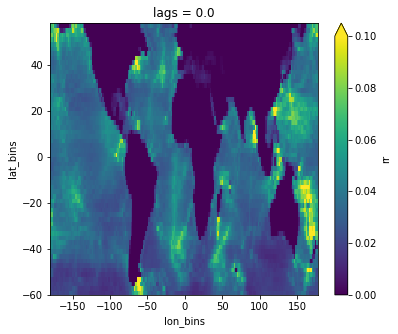

In [27]:
fig,ax = plt.subplots(figsize=(6,5))
np.sqrt(ds_out.isel(lags=0).rr).plot(vmax=0.1,y='lat_bins',ax=ax)

In [15]:
#client.restart()
#
cluster.close()

tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x2aabca829940>, <Task finished name='Task-84567' coro=<BaseTCPListener._handle_stream() done, defined at /home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/comm/tcp.py:513> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/tcpserver.py", line 331, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/comm/tcp.py", line 519, in _handle_stream
    logger.debug("Incoming connection from %r to %r", address, self.contact_address)
  F